In [2]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
conn = pymysql.connect(
    host="localhost",
    user="root",
    password="",
    database="store_sales"
)

query = "select * FROM vistaglobal"

df = pd.read_sql(query, conn)

conn.close()

print("✅ Datos cargados desde la vista:")
print(f"\nTotal de filas: {len(df)}")


/var/folders/s0/nvzx41d92wn4_49xlp1981tw0000gn/T/ipykernel_5121/58760735.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ Datos cargados desde la vista:

Total de filas: 81685


In [4]:
df['locale'].value_counts()

locale
Local    214
Name: count, dtype: int64

In [5]:
df['locale'].unique()

array([None, 'Local'], dtype=object)

In [6]:
import pandas as pd

# Asegúrate de que 'fecha' sea datetime y esté ordenado
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha').reset_index(drop=True)

for idx, row in df[df['precioGlobal'].isnull()].iterrows():
    fecha_actual = row['fecha']

    # 1️⃣ Buscar valor en la misma fecha
    mismo_dia = df[(df['fecha'] == fecha_actual) & (df['precioGlobal'].notnull())]
    if not mismo_dia.empty:
        df.at[idx, 'precioGlobal'] = mismo_dia['precioGlobal'].mean()
        continue

    # 2️⃣ Buscar anterior y posterior más cercanos (iterando hasta encontrar ambos)
    anterior = None
    posterior = None
    step = 1

    while anterior is None or posterior is None:
        # Buscar hacia atrás
        if anterior is None:
            fila_ant = df[(df['fecha'] < fecha_actual - pd.Timedelta(days=step)) & (df['precioGlobal'].notnull())].tail(1)
            if not fila_ant.empty:
                anterior = fila_ant['precioGlobal'].values[0]
        # Buscar hacia adelante
        if posterior is None:
            fila_post = df[(df['fecha'] > fecha_actual + pd.Timedelta(days=step)) & (df['precioGlobal'].notnull())].head(1)
            if not fila_post.empty:
                posterior = fila_post['precioGlobal'].values[0]
        step += 1

    # 3️⃣ Calcular la media entre anterior y posterior más cercanos
    df.at[idx, 'precioGlobal'] = (anterior + posterior) / 2

print("✅ Nulos tratados con lógica avanzada.")


✅ Nulos tratados con lógica avanzada.


In [7]:
import seaborn as sns

# 1️⃣ Resumen general
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81685 entries, 0 to 81684
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fecha          81685 non-null  datetime64[ns]
 1   lugar          81685 non-null  object        
 2   idTienda       81685 non-null  int64         
 3   transacciones  81685 non-null  int64         
 4   formatoTienda  81685 non-null  object        
 5   cluster        81685 non-null  int64         
 6   precioGlobal   81685 non-null  float64       
 7   type           214 non-null    object        
 8   locale         214 non-null    object        
 9   dia            81685 non-null  int64         
 10  mes            81685 non-null  int64         
 11  ano            81685 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 7.5+ MB
None
                               fecha      idTienda  transacciones  \
count                 

In [8]:
print("\n📊 Valores únicos por columna categórica:")
for col in ['lugar', 'formatoTienda', 'type', 'locale','cluster']:
    print(f"{col}: {df[col].unique()}")


📊 Valores únicos por columna categórica:
lugar: ['Pichincha - Quito' 'Guayas - Guayaquil' 'Los Rios - Babahoyo'
 'Los Rios - Quevedo' 'Guayas - Playas' 'Azuay - Cuenca' 'Loja - Loja'
 'El Oro - Machala' 'Tungurahua - Ambato' 'Manabi - El Carmen'
 'Esmeraldas - Esmeraldas' 'Guayas - Daule' 'Santa Elena - Salinas'
 'Santo Domingo de los Tsachilas - Santo Domingo' 'Pichincha - Cayambe'
 'Cotopaxi - Latacunga' 'Bolivar - Guaranda' 'Imbabura - Ibarra'
 'Chimborazo - Riobamba' 'Guayas - Libertad' 'Manabi - Manta'
 'Pastaza - Puyo']
formatoTienda: ['D' 'C' 'B' 'E' 'A']
type: [None 'Holiday']
locale: [None 'Local']
cluster: [13  3 10  6  2  4  5 11 14 17  1  8  9 15 16  7 12]


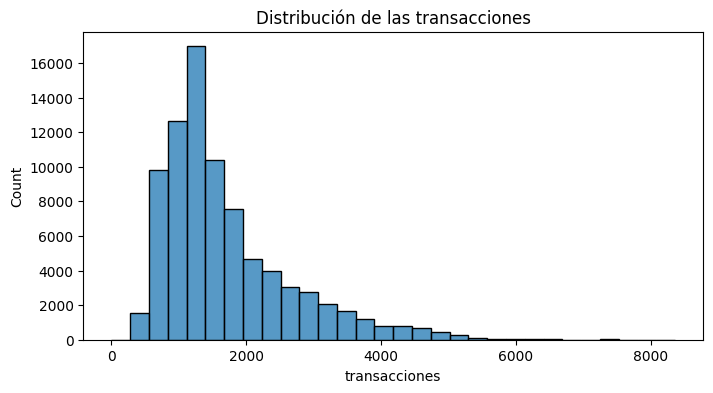

In [9]:
plt.figure(figsize=(8,4))
sns.histplot(df['transacciones'], bins=30)
plt.title("Distribución de las transacciones")
plt.show()


⚠️ Valor del percentil 95: 4868.0
🔍 Número de outliers: 816


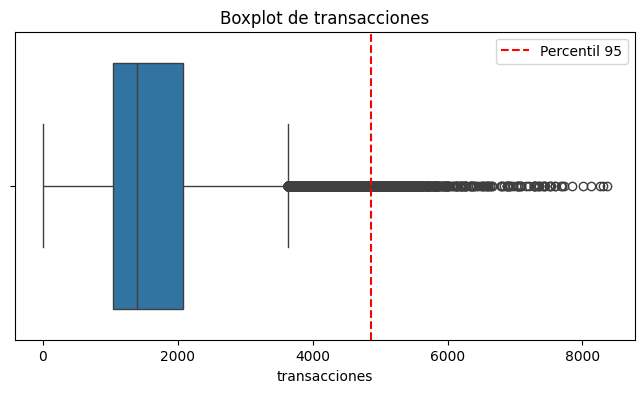

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular percentil 95
percentil_95 = df['transacciones'].quantile(0.99)
print(f"⚠️ Valor del percentil 95: {percentil_95}")

# Filtrar los outliers por encima del percentil 95
outliers = df[df['transacciones'] > percentil_95]
print(f"🔍 Número de outliers: {outliers.shape[0]}")

# Visualización con boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['transacciones'])
plt.title("Boxplot de transacciones")
plt.axvline(percentil_95, color='r', linestyle='--', label='Percentil 95')
plt.legend()
plt.show()


In [11]:
df.shape

(81685, 12)

In [12]:
df = df[df['transacciones'] < percentil_95]
df.shape

(80866, 12)

In [13]:
df["type"]= df["type"].apply(lambda x:1 if x == 'Holiday' else 0)



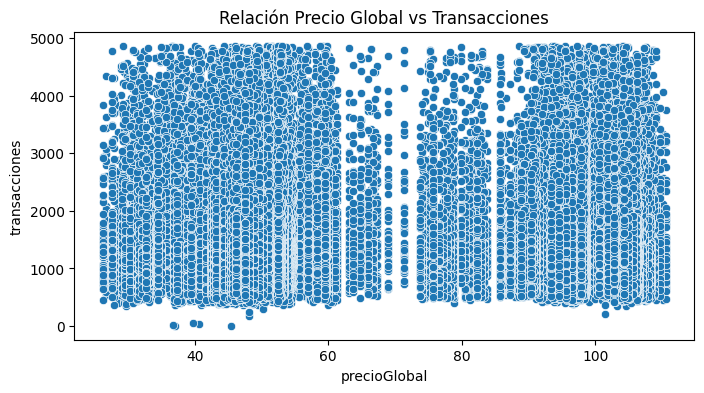

In [14]:
# 4️⃣ Relación transacciones vs precioGlobal
plt.figure(figsize=(8,4))
sns.scatterplot(data=df, x='precioGlobal', y='transacciones')
plt.title("Relación Precio Global vs Transacciones")
plt.show()

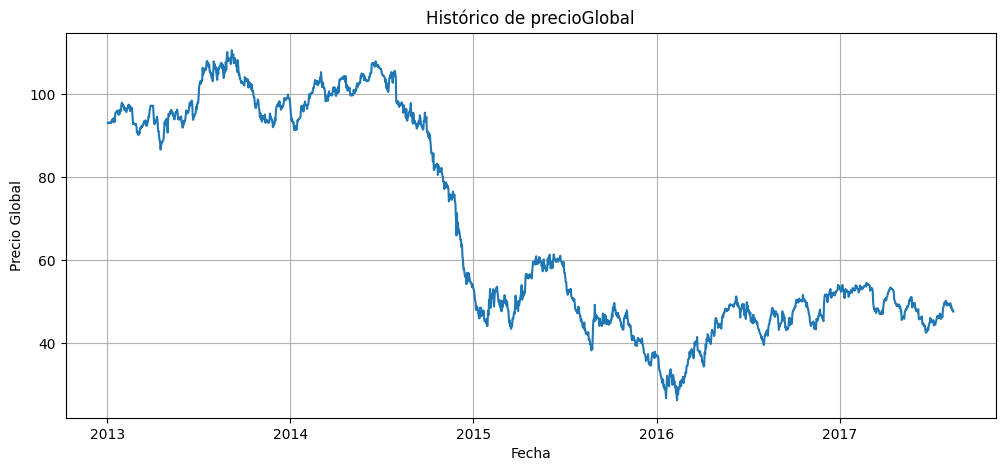

In [15]:
plt.figure(figsize=(12,5))
df.sort_values('fecha', inplace=True)
plt.plot(df['fecha'], df['precioGlobal'])
plt.title("Histórico de precioGlobal")
plt.xlabel("Fecha")
plt.ylabel("Precio Global")
plt.grid(True)
plt.show()


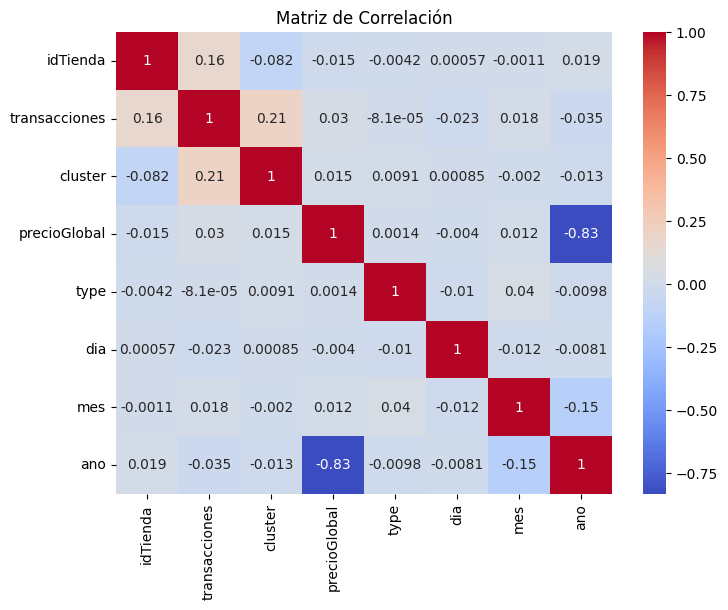

In [16]:
# 6️⃣ Correlación numérica
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import numpy as np

# 1️⃣ Features y target
X = df.drop(columns=['transacciones', 'fecha'])
y = df['transacciones']

# 2️⃣ Encoding simple para categóricas
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 3️⃣ Crear Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300,  # Número de árboles
    max_depth=10,      # Profundidad máxima
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

# 4️⃣ Validación cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')

print(f"🚀 RMSE medio en validación cruzada: {-np.mean(cv_scores):.2f}")
print(f"📊 RMSEs individuales: {-cv_scores}")

# 5️⃣ Entrenamiento final con todo el dataset
rf_model.fit(X, y)
print("✅ Modelo Random Forest entrenado.")



🚀 RMSE medio en validación cruzada: 285.12
📊 RMSEs individuales: [281.03126329 289.9881305  285.8668739  280.76566583 287.92454931]
✅ Modelo Random Forest entrenado.


max_depth=3 | RMSE medio: 488.17
max_depth=5 | RMSE medio: 367.54
max_depth=7 | RMSE medio: 315.22
max_depth=10 | RMSE medio: 285.14
max_depth=12 | RMSE medio: 283.07
max_depth=15 | RMSE medio: 285.00
max_depth=20 | RMSE medio: 289.41


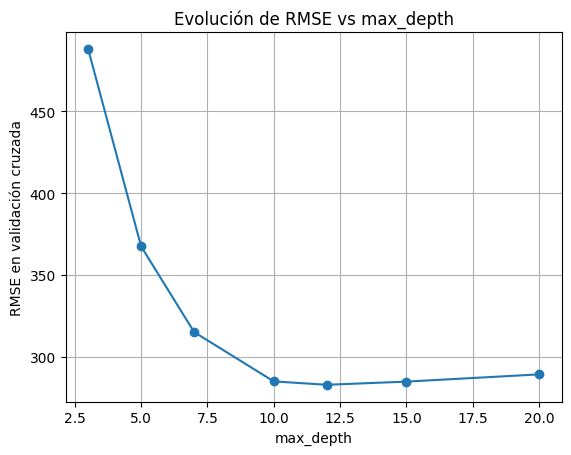

In [18]:
import matplotlib.pyplot as plt

max_depths = [3, 5, 7, 10, 12, 15, 20]
rmse_results = []

for depth in max_depths:
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=depth,
        min_samples_split=5,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    )
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf_model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
    rmse_mean = -np.mean(cv_scores)
    rmse_results.append(rmse_mean)
    print(f"max_depth={depth} | RMSE medio: {rmse_mean:.2f}")

# 📈 Plot
plt.plot(max_depths, rmse_results, marker='o')
plt.xlabel("max_depth")
plt.ylabel("RMSE en validación cruzada")
plt.title("Evolución de RMSE vs max_depth")
plt.grid(True)
plt.show()


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import numpy as np

# 1️⃣ Features y target
X = df.drop(columns=['transacciones', 'fecha'])
y = df['transacciones']

# 2️⃣ Encoding simple para categóricas
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 3️⃣ Crear Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300,  # Número de árboles
    max_depth=10,      # Profundidad máxima
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

# 4️⃣ Validación cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')

print(f"🚀 RMSE medio en validación cruzada: {-np.mean(cv_scores):.2f}")
print(f"📊 RMSEs individuales: {-cv_scores}")

# 5️⃣ Entrenamiento final con todo el dataset
rf_model.fit(X, y)
print("✅ Modelo Random Forest entrenado.")

🚀 RMSE medio en validación cruzada: 285.12
📊 RMSEs individuales: [281.03126329 289.9881305  285.8668739  280.76566583 287.92454931]
✅ Modelo Random Forest entrenado.
